# 1. Importing library and setting device

In [1]:
import torch  # Pytorch
import torch.nn as nn  # Neural network module
import torch.nn.functional as fn  # Function module
from torchvision import datasets  # Datasets from torchvision
from torchvision import transforms  # Transforms from torchvision
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

import matplotlib.pyplot as plt  # Plotting using matplotlib
import numpy as np  # Numpy


if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print("Running on " + device)

Running on cuda


# 2. Preparing dataset

In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

from torchvision.datasets import MNIST

transform = transforms.ToTensor()

train_data = MNIST("./", download=True, train=True, transform=transform)
test_data = MNIST("./", download=True, train=False, transform=transform)

X_train, X_test = train_test_split(train_data, test_size=0.05, random_state=42)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# 3. Autoencoder architecture

In [3]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(True),
            nn.Linear(512, 128),
            nn.ReLU(True), 
            nn.Linear(128, 64), 
            nn.ReLU(True), 
            nn.Linear(64, 9),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(9, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 512),
            nn.ReLU(True), 
            nn.Linear(512, 28 * 28),
            nn.Sigmoid())

    def forward(self, x):
        x = torch.flatten(x, start_dim = 1)
        x = self.encoder(x)
        x = self.decoder(x)
        x.reshape((-1,1,28,28))
        return x

autoencoder = autoencoder().to(device)

# 4. Loss function

In [4]:
def get_loss2d(pred, original):
    h = 28
    # penalty function
    window = torch.ones(h*h)
    window[378] = 0
    window = window.to(device)

    # Creating toeplitz matrix A
    x = original.squeeze().to(device)
    C = torch.zeros((2*h-1, 2*h-1, h)).to(device)
    for i in range(h):
        toep = torch.zeros((h, 2*h-1)).to(device)
        z = torch.zeros(2*h-1-h).to(device)
        a = torch.cat([x[i], z], dim = 0)
        for j in range(h):
            toep[j] = torch.roll(a, j)
        toep = torch.transpose(toep, 0, 1)
        C[i] = toep

    A = C.reshape(((2*h-1)**2, h))
    for j in range(1, h):
        A = torch.hstack((A, torch.roll(C, j, dims=-3).reshape(((2*h-1)**2), h)))
    A_T = torch.transpose(A, 0, 1).to(device)

    # Creating padded vector b

    # top padding
    tp = torch.zeros(int((2*h-1-h)/2), 2*h-1).to(device)
    # bottom padding
    bp = torch.zeros(2*h-1-h-int((2*h-1-h)/2), 2*h-1).to(device)
    # right padding
    rp = torch.zeros((h, int((2*h-1-h)/2))).to(device)
    # left padding 
    lp = torch.zeros((h, 2*h-1-h-int((2*h-1-h)/2))).to(device)
    # Stacking padding
    b = torch.hstack((lp, pred.squeeze().to(device), rp))
    b = torch.vstack((tp, b, bp))

    b = b.view((2*h-1)**2)

    inv = torch.inverse(A_T @ A)

    w = inv @ A_T @ b

    
    #w2 = w.cpu().detach().numpy()
    #plt.plot(w2)
    #plt.show()

    # Calculating loss for pred[k]
    loss = 0.5 * torch.sum((window * w)**2)
    
    return loss.to(device)

# 5. Training function

Epoch: 1 	Training Loss: 0.409195
Epoch: 2 	Training Loss: 0.403813
Epoch: 3 	Training Loss: 0.398587
Epoch: 4 	Training Loss: 0.393506
Epoch: 5 	Training Loss: 0.388555
Epoch: 6 	Training Loss: 0.383727
Epoch: 7 	Training Loss: 0.379000
Epoch: 8 	Training Loss: 0.374365
Epoch: 9 	Training Loss: 0.369809
Epoch: 10 	Training Loss: 0.365324
Epoch: 11 	Training Loss: 0.360902
Epoch: 12 	Training Loss: 0.356549
Epoch: 13 	Training Loss: 0.352250
Epoch: 14 	Training Loss: 0.347986
Epoch: 15 	Training Loss: 0.343758
Epoch: 16 	Training Loss: 0.339575
Epoch: 17 	Training Loss: 0.335420
Epoch: 18 	Training Loss: 0.331297
Epoch: 19 	Training Loss: 0.327196
Epoch: 20 	Training Loss: 0.323114
Epoch: 21 	Training Loss: 0.319046
Epoch: 22 	Training Loss: 0.315009
Epoch: 23 	Training Loss: 0.310998
Epoch: 24 	Training Loss: 0.307010
Epoch: 25 	Training Loss: 0.303036
Epoch: 26 	Training Loss: 0.299073
Epoch: 27 	Training Loss: 0.295126
Epoch: 28 	Training Loss: 0.291193
Epoch: 29 	Training Loss: 0.2

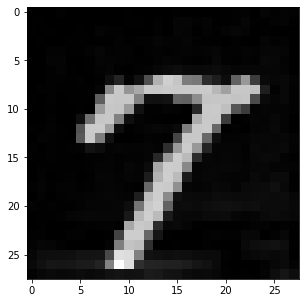

In [5]:
def train(autoencoder, train_image, kl_div_on=True, n_epochs=100):
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)
    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0
      
        ###################
        # train the model #
        ###################
        
        # model.train()
        # _ stands in for labels, here
        # no need to flatten images
        image, y = train_image
        image = image.view((1, 1, 28, 28))
        image = image.to(device)
        #images = images.to(device)
        optimizer.zero_grad()
        pred = autoencoder(image)
        pred = pred.view((1, 1, 28, 28))

        loss = get_loss2d(pred, image)

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()
                
        # print avg training statistics 
        train_loss = train_loss
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss
            ))
    return autoencoder

# one image for training
tao_train = X_train[0]
a, b = tao_train
autoencoder = train(autoencoder, tao_train, n_epochs = 1000)

import matplotlib.pyplot as plt
%matplotlib inline

a = a.view((1, 1, 28, 28)).to(device)
p = autoencoder(a)
p = p.view((1, 1, 28, 28))
print(p.size())
image = p.cpu().detach().numpy()

img = np.squeeze(image)

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')


# 6. Comparison with the original image

torch.Size([1, 1, 28, 28])


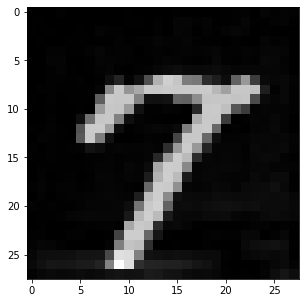

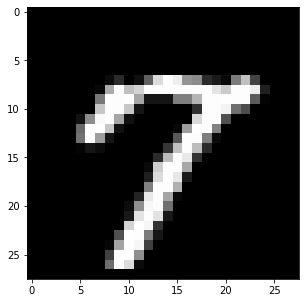

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline


# Predicted
tao_train = X_train[0]
a, b = tao_train
a = a.view((1, 1, 28, 28)).to(device)
p = autoencoder(a)
p = p.view((1, 1, 28, 28))
print(p.size())
image = p.cpu().detach().numpy()

img = np.squeeze(image)

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

# Original image
tao_train = X_train[0]
a, b = tao_train
a = a.view((1, 1, 28, 28))
image = a.cpu().detach().numpy()

img = np.squeeze(a)

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')